In [8]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from keras.utils import to_categorical

import sys

import numpy as np

class GAN():
    
    def init_v17_v10_plot(self):
        self.fig, self.axes = plt.subplots(nrows=6, ncols=2, figsize=(14,18))
        self.col1, self.col2 = 'V17', 'V10'
        self.plot_counter = 0

        for i in range(6):

            self.data_fraud.plot(kind='scatter', ax=self.axes[i,0], x = self.col1, y = self.col2)

            self.axes[i, 0].set_title('Actual Fraud') 
            
    def init_v17_v14_plot(self):
        self.fig, self.axes = plt.subplots(nrows=6, ncols=2, figsize=(14,18))
        self.col1, self.col2 = 'V17', 'V14'
        self.plot_counter = 0

        for i in range(6):

            self.data_fraud.plot(kind='scatter', ax=self.axes[i,0], x = self.col1, y = self.col2)

            self.axes[i, 0].set_title('Actual Fraud') 
        
    def load_fraud_data(self):
        # Read in dataset from csv file
        data = pd.read_csv("creditcard.csv")
        
        # Take only the fraud examples
        data_fraud = data.loc[data['Class'] == 1]
        
        # Remove class column as not needed, these are all Class=1
        data_fraud = data_fraud.loc[:, data_fraud.columns != 'Class']
        self.data_cols = data_fraud.columns
        
        # Scale data using StandardScaler
        pipeline = Pipeline([
        ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(data_fraud)
        data_fraud = preprocessor.transform(data_fraud)
        data_fraud = pd.DataFrame(data_fraud, columns=self.data_cols)
        
        self.data_fraud = data_fraud
        
    def load_raw_data(self):
        return pd.read_csv("creditcard.csv")
        
    def __init__(self):
        self.img_rows = 1 
        self.img_cols = 30
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)
        
        # Load fraud data 
        self.load_fraud_data()
        self.data_raw = self.load_raw_data()
        
        # Initialise the data plot grid
#         self.init_v17_v10_plot()
        self.init_v17_v10_plot()

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy','categorical_crossentropy'],
            loss_weights=[0.5, 0.5],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss=['binary_crossentropy'], optimizer=optimizer)

        # The generator takes noise as input and generates imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid, _ = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)
    

    
    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape))) # , activation='tanh'
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
#         model.add(Dense(2, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)
        

        valid = Dense(1, activation="sigmoid")(validity)
        label = Dense(3, activation="softmax")(validity)

        return Model(img, [valid, label])
#         return Model(img, label)
    
    def generate_train_test_sample(self, data, test_ratio=0.3): 
        
        # Assign variables x and y corresponding to row data and it's class value
        X = data.ix[:, data.columns != 'Class']
        y = data.ix[:, data.columns == 'Class']

        # performs random split (i.e random selects 70% datapoints)
        X_train, X_test, y_train, y_test = train_test_split(X,y)
        
        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(X_train)
        X_train_prp = preprocessor.transform(X_train)

        X_test_prp = preprocessor.transform(X_test)

        return X_train_prp, X_test_prp, y_train, y_test
    
    def generate_train_test_timeseries(data, test_ratio=0.3):

        total_samples = data.shape[0]

        cutoff = int(total_samples * (1 - test_ratio))

        data.sort_values('Time', inplace=True)

        X_train = data.loc[0:cutoff, data.columns != 'Class']
        y_train = data.loc[0:cutoff, data.columns == 'Class']
        X_test = data.loc[cutoff:, data.columns != 'Class']
        y_test = data.loc[cutoff:, data.columns == 'Class']

        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(X_train)
        X_train_prp = preprocessor.transform(X_train)

        X_test_prp = preprocessor.transform(X_test)



        return X_train_prp, y_train, X_test_prp, y_test
    

    def train(self, epochs, batch_size=128, save_interval=200):
        
        data_cols = self.data_cols
        # Load the dataset
        X_train = self.data_fraud.values
        
        X_train, X_test, y_train, y_test = self.generate_train_test_sample(self.data_raw)
        
        X_train = np.expand_dims(X_train, axis=3)
        X_train = np.expand_dims(X_train, axis=1)
        y_train = np.expand_dims(y_train, axis=1)

        half_batch = int(batch_size / 2)
        self.losses = []
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]
            imgs_ys = y_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)
            
            self.discriminator.trainable = True
            # Train the discriminator
#             X = np.concatenate((imgs,gen_imgs))
#             y = np.zeros([len(imgs)+len(gen_imgs),3])
#             y[0:len(imgs),2] = [i[0][0] for i in imgs_ys]
#             y[0:len(imgs),1] = 1
#             y[len(imgs):,0] = 1
            
            valid = np.ones((half_batch, 1))
            fake = np.zeros((half_batch, 1))

            labels = to_categorical(imgs_ys, num_classes=3)
            fake_labels = to_categorical(np.full((half_batch, 1), 2), num_classes=3)
            
#             d_loss = self.discriminator.train_on_batch(X, y)
#             d_loss = [0.5 * (i+j) for i,j in (d_loss_real, d_loss_fake)]
#             d_loss = 0.5*(d_loss_real[0]+d_loss_fake[0])
#             d_acc = 0.5*(d_loss_real[1]+d_loss_fake[1])

            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, labels])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            self.discriminator.trainable = False

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
#             valid_y = np.array([1] * batch_size)
#             valid_y = np.zeros([batch_size,2])
#             valid_y[:,1] = 1

            valid_y = np.ones((batch_size, 1))
            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)
            
            self.losses.append((d_loss, g_loss))

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch, imgs, gen_imgs)
                
        self.save_loss_plot()
        
    def save_loss_plot(self):
        losses = np.array(self.losses)

        fig, ax = plt.subplots()
        plt.plot([i[0][0] for i in losses], label='Discriminator')
        plt.plot([i[1] for i in losses], label='Generator')
        plt.title("Training Losses")
        plt.legend()
        
        fig.savefig("GANv1-ssl-losses.png")
        plt.close()
        
    def save_imgs(self, epoch, img, gen_imgs):

        col1, col2 = 'V17', 'V10'
        noise = np.random.normal(0, 1, (492, 100))
        print(noise.shape)

            # Generate a half batch of new images
        gen_imgs = self.generator.predict(noise)

        gen_imgs = gen_imgs.reshape(gen_imgs.shape[0], gen_imgs.shape[2])
        print (gen_imgs.shape)
        gen_samples = pd.DataFrame(gen_imgs, columns=self.data_cols)
        
        gen_samples.plot(kind='scatter', ax=self.axes[self.plot_counter,1], x = col1, y = col2)
        self.plot_counter = self.plot_counter +1
        
        if self.plot_counter == 6:
            self.fig.tight_layout()
            self.fig.savefig("GANv1-ssl-v17-v10-img_2.png")
            plt.close()
            
    
    def test_as_classifier(self):
        from sklearn.metrics import confusion_matrix, classification_report
        
        data_raw = pd.read_csv("creditcard.csv")
    
        X_train, X_test, y_train, y_test = self.generate_train_test_sample(data_raw)
        X_test = np.expand_dims(X_test, axis=3)
        X_test = np.expand_dims(X_test, axis=1)
        y_pred = self.discriminator.predict(X_test)

        cutt_off_tr = 0.5
        y_pred[np.where(y_pred>=cutt_off_tr)] = 1
        y_pred[np.where(y_pred<cutt_off_tr)]  = 0
        prfs = precision_recall_fscore_support(y_test, y_pred, labels=[1])
        prfs0 = precision_recall_fscore_support(y_test, y_pred, labels=[0])
        
        print(prfs)
        print(prfs0)
        
        print(classification_report(
        y_test,
        y_pred,
        target_names = ["Genuine", "Fraud"],
        digits = 5))
        
        print (confusion_matrix(
        y_test,
        y_pred))
        
        from sklearn.metrics import roc_curve, auc, roc_auc_score

        # short way
        print(roc_auc_score(y_test, y_pred))
        


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=6000, batch_size=32, save_interval=1000)
    gan.test_as_classifier()
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 512)               15872     
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 256)               0         
Total params: 147,200
Trainable params: 147,200
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:219: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
0 [D loss: 0.865818, acc.: 65.31%] [G loss: 0.560404]
(492, 100)
(492, 30)
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
1 [D loss: 0.807288, acc.: 62.86%] [G loss: 0.514903]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
2 [D loss: 0.809263, acc.: 64.11%] [G loss: 0.477318]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
3 [D loss: 0.810215, acc.: 67.43%] [G loss: 0.468529]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
4 [D loss: 0.795868, acc.: 66.09%] [G loss: 0.390076]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]

50 [D loss: 0.667234, acc.: 68.65%] [G loss: 0.944968]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
51 [D loss: 0.713590, acc.: 73.15%] [G loss: 0.931685]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
52 [D loss: 0.671735, acc.: 70.82%] [G loss: 0.956907]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
53 [D loss: 0.671715, acc.: 68.93%] [G loss: 0.924033]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
54 [D loss: 0.677271, acc.: 69.88%] [G loss: 0.938494]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
55 [D loss: 0.746414, acc.: 75.86%] [G loss: 0.899706]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

98 [D loss: 0.659508, acc.: 68.26%] [G loss: 0.846866]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
99 [D loss: 0.652459, acc.: 68.34%] [G loss: 0.851644]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
100 [D loss: 0.700434, acc.: 71.80%] [G loss: 0.843857]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
101 [D loss: 0.650927, acc.: 66.34%] [G loss: 0.846995]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
102 [D loss: 0.665047, acc.: 67.90%] [G loss: 0.845924]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
103 [D loss: 0.689002, acc.: 71.87%] [G loss: 0.833543]
[[[0]]

 [[0]]

 [[0]]

 [

144 [D loss: 0.684614, acc.: 69.12%] [G loss: 0.721815]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
145 [D loss: 0.671812, acc.: 68.93%] [G loss: 0.724962]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
146 [D loss: 0.704989, acc.: 70.00%] [G loss: 0.724503]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
147 [D loss: 0.688121, acc.: 69.11%] [G loss: 0.722457]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
148 [D loss: 0.649093, acc.: 66.15%] [G loss: 0.721077]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
149 [D loss: 0.679328, acc.: 69.87%] [G loss: 0.737043]
[[[0]]

 [[0]]

 [[0]]



195 [D loss: 0.665814, acc.: 67.37%] [G loss: 0.729297]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
196 [D loss: 0.637053, acc.: 64.30%] [G loss: 0.733163]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
197 [D loss: 0.698414, acc.: 69.41%] [G loss: 0.744688]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
198 [D loss: 0.660750, acc.: 65.75%] [G loss: 0.747291]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
199 [D loss: 0.713276, acc.: 70.41%] [G loss: 0.750250]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
200 [D loss: 0.647147, acc.: 65.54%] [G loss: 0.760167]
[[[0]]

 [[0]]

 [[0]]



246 [D loss: 0.676978, acc.: 68.33%] [G loss: 0.704986]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
247 [D loss: 0.680762, acc.: 69.40%] [G loss: 0.710095]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
248 [D loss: 0.656938, acc.: 67.15%] [G loss: 0.707065]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
249 [D loss: 0.646774, acc.: 65.91%] [G loss: 0.716700]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
250 [D loss: 0.653379, acc.: 66.32%] [G loss: 0.738841]
[[[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]

 [[0]]]
251 [D loss: 0.705930, acc.: 70.77%] [G loss: 0.733406]
[[[0]]

 [[0]]

 [[0]]



KeyboardInterrupt: 

<__main__.GAN instance at 0x162120320>

In [17]:
gan.losses

[([0.74208075, 0.484375], 0.87357593),
 ([0.75348449, 0.46875], 0.8161),
 ([0.71420693, 0.515625], 0.72839844),
 ([0.68920028, 0.6875], 0.67272639),
 ([0.67942798, 0.640625], 0.62539434),
 ([0.6885553, 0.5625], 0.60943216),
 ([0.66656232, 0.609375], 0.58675754),
 ([0.67368591, 0.5625], 0.56529897),
 ([0.68674004, 0.453125], 0.57941085),
 ([0.70802993, 0.453125], 0.56557679),
 ([0.70535445, 0.453125], 0.57909566),
 ([0.68469334, 0.640625], 0.62062335),
 ([0.71195579, 0.5625], 0.64273894),
 ([0.70664167, 0.515625], 0.70106304),
 ([0.71455342, 0.59375], 0.74432713),
 ([0.72992188, 0.40625], 0.80960166),
 ([0.68420899, 0.59375], 0.8596397),
 ([0.67457342, 0.5625], 0.88688713),
 ([0.62086171, 0.6875], 0.95859313),
 ([0.7143482, 0.46875], 0.963121),
 ([0.63307703, 0.6875], 0.99627405),
 ([0.64046401, 0.578125], 1.0523771),
 ([0.62096083, 0.5625], 1.0434482),
 ([0.64174235, 0.546875], 1.0985436),
 ([0.6344102, 0.53125], 1.1083629),
 ([0.62096292, 0.5625], 1.0122991),
 ([0.65543342, 0.515625],

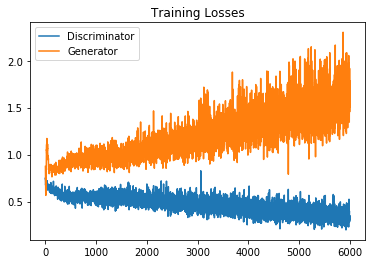

In [18]:
losses = np.array(gan.losses)

fig, ax = plt.subplots()
plt.plot([i[0][0] for i in losses], label='Discriminator')
plt.plot([i[1] for i in losses], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

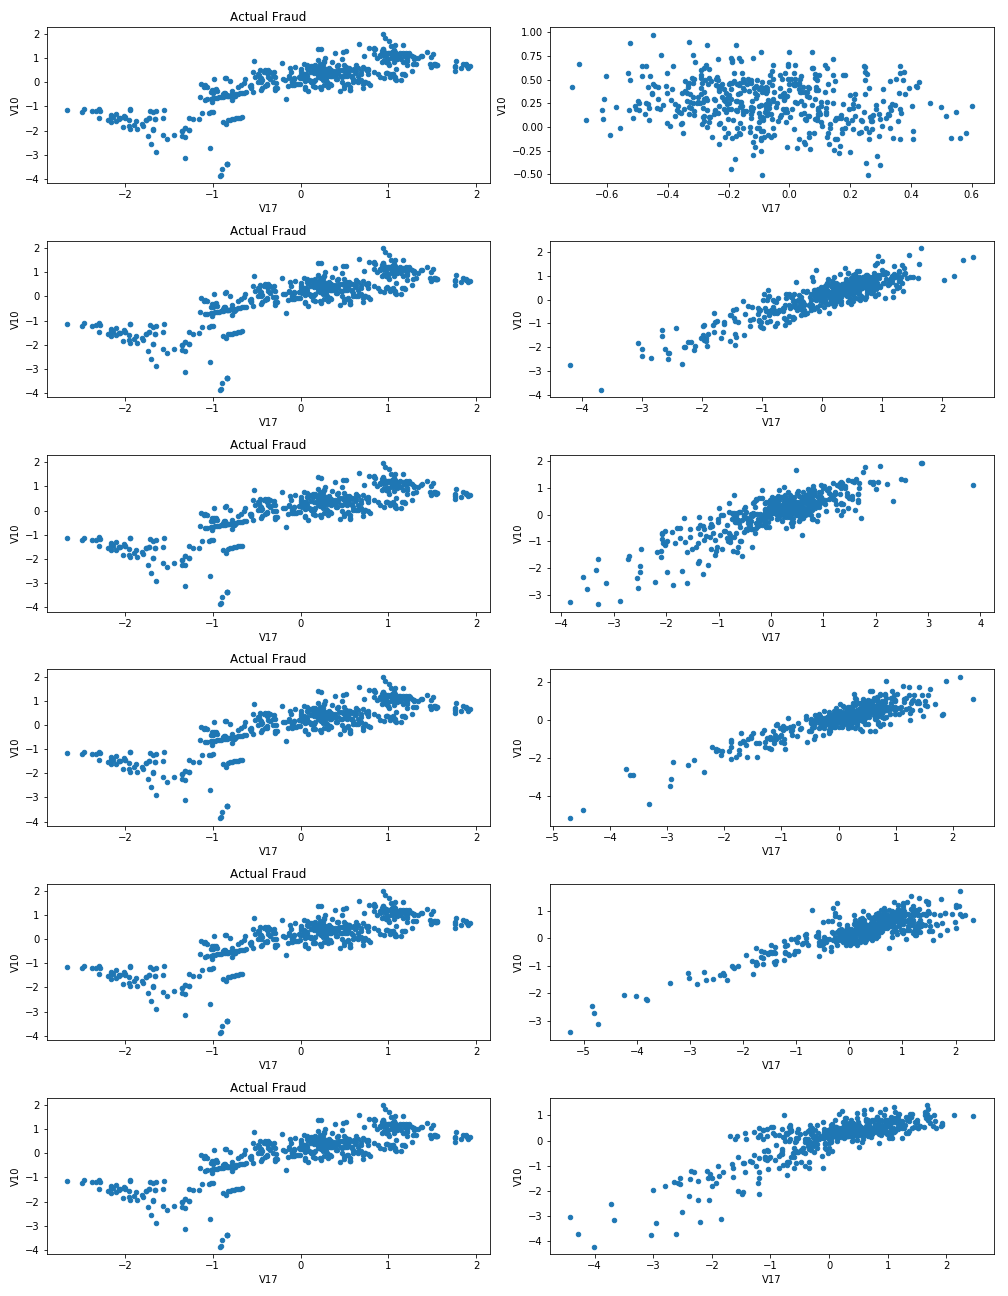

In [1]:
from IPython.display import Image
Image(filename='GANv1-v17-v10-img_2.png')

In [66]:
plt.figure()

In [15]:
plt.close()

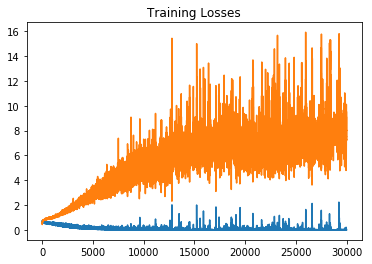

In [68]:
fig